In [ ]:
# # Install core ML libraries and deep learning frameworks
# !pip install -U scikit-learn xgboost lightgbm tensorflow scikeras seaborn matplotlib pandas

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
)
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from scikeras.wrappers import KerasRegressor
import itertools
from sklearn.model_selection import cross_val_score
import warnings

warnings.filterwarnings("ignore")

In [30]:
# Read CSV
file_path = "DataV2.csv"
df = pd.read_csv(file_path)

In [31]:
print(df.head())

         fW   current           ind      Rd            Cs      Rs  \
0  0.000006  0.000562  1.510000e-10   649.3  6.820000e-13  1431.0   
1  0.000009  0.002422  2.230000e-09  1415.0  2.090000e-14   270.0   
2  0.000007  0.001013  2.080000e-09   863.9  9.450000e-13   243.7   
3  0.000010  0.002243  1.730000e-09   518.5  3.510000e-13  1067.0   
4  0.000007  0.001158  2.370000e-09   332.5  9.840000e-14   650.5   

   channel 0.1G attenuation  channel 3.5G attenuation  channel 7G attenuation  \
0                  -0.01970                    -6.589                  -9.105   
1                  -0.02002                    -6.610                  -9.109   
2                  -0.01961                    -6.591                  -9.102   
3                  -0.01954                    -6.604                  -9.111   
4                  -0.01968                    -6.578                  -9.095   

   channel 14G attenuation  ...  eye_maxHeight Vout_2 14G  \
0                   -13.18  ...      

In [32]:
target_cols = [
    # Attenuation
    "stage 1 3.5G attenuation",
    "stage 2 3.5G attenuation",
    "stage 1 7G attenuation",
    "stage 2 7G attenuation",
    "stage 1 14G attenuation",
    "stage 2 14G attenuation",
    "stage 1 28G attenuation",
    "stage 2 28G attenuation",
    # Eye metrics - 7G
    "eye_maxHeight Vout_1 7G",
    "eye_maxWidth Vout_1 7G",
    "eye_maxHeight Vout_2 7G",
    "eye_maxWidth Vout_2 7G",
    # Eye metrics - 14G
    "eye_maxHeight Vout_1 14G",
    "eye_maxWidth Vout_1 14G",
    "eye_maxHeight Vout_2 14G",
    "eye_maxWidth Vout_2 14G",
    # Eye metrics - 28G
    "eye_maxHeight Vout_1 28G",
    "eye_maxWidth Vout_1 28G",
    "eye_maxHeight Vout_2 28G",
    "eye_maxWidth Vout_2 28G",
    # Eye metrics - 56G
    "eye_maxHeight Vout_1 56G",
    "eye_maxWidth Vout_1 56G",
    "eye_maxHeight Vout_2 56G",
    "eye_maxWidth Vout_2 56G",
]

In [33]:
feature_columns = [col for col in df.columns if col not in target_cols]

In [34]:
# Split features and targets
X = df[feature_columns].copy()
y = df[target_cols].copy()

In [35]:
print(f"\nFeature columns ({len(feature_columns)}):", feature_columns)
print(f"Target columns ({len(target_cols)}):", target_cols)
print(f"Features shape: {X.shape}")
print(f"Targets shape: {y.shape}")


Feature columns (15): ['fW', 'current', 'ind', 'Rd', 'Cs', 'Rs', 'channel 0.1G attenuation', 'channel 3.5G attenuation', 'channel 7G attenuation', 'channel 14G attenuation', 'channel 28G attenuation', 'Stage 1 Region', 'stage 1 0.1G attenuation', 'stage 2 0.1G attenuation', 'Hard Constraint of neg2 on 0.1G Status']
Target columns (24): ['stage 1 3.5G attenuation', 'stage 2 3.5G attenuation', 'stage 1 7G attenuation', 'stage 2 7G attenuation', 'stage 1 14G attenuation', 'stage 2 14G attenuation', 'stage 1 28G attenuation', 'stage 2 28G attenuation', 'eye_maxHeight Vout_1 7G', 'eye_maxWidth Vout_1 7G', 'eye_maxHeight Vout_2 7G', 'eye_maxWidth Vout_2 7G', 'eye_maxHeight Vout_1 14G', 'eye_maxWidth Vout_1 14G', 'eye_maxHeight Vout_2 14G', 'eye_maxWidth Vout_2 14G', 'eye_maxHeight Vout_1 28G', 'eye_maxWidth Vout_1 28G', 'eye_maxHeight Vout_2 28G', 'eye_maxWidth Vout_2 28G', 'eye_maxHeight Vout_1 56G', 'eye_maxWidth Vout_1 56G', 'eye_maxHeight Vout_2 56G', 'eye_maxWidth Vout_2 56G']
Features

In [36]:
numerical_features = [
    "fW",
    "current",
    "ind",
    "Rd",
    "Cs",
    "Rs",
    "channel 0.1G attenuation",
    "channel 3.5G attenuation",
    "channel 7G attenuation",
    "channel 14G attenuation",
    "channel 28G attenuation",
    "stage 1 0.1G attenuation",
    "stage 2 0.1G attenuation",
]

In [ ]:
categorical_features = [
    "Stage 1 Region",
    "Hard Constraint of neg2 on 0.1G Status",
]  # Assuming this is the only remaining categorical to encode

In [38]:
# Ensure only existing columns are included
numerical_features = [f for f in numerical_features if f in X.columns]
categorical_features = [f for f in categorical_features if f in X.columns]

In [39]:
print(numerical_features)

['fW', 'current', 'ind', 'Rd', 'Cs', 'Rs', 'channel 0.1G attenuation', 'channel 3.5G attenuation', 'channel 7G attenuation', 'channel 14G attenuation', 'channel 28G attenuation', 'stage 1 0.1G attenuation', 'stage 2 0.1G attenuation']


In [40]:
print(categorical_features)

['Stage 1 Region']


In [41]:
# Check for missing features
all_defined_features = set(numerical_features + categorical_features)
actual_features = set(X.columns)
missing_features = actual_features - all_defined_features
if missing_features:
    print(
        f"\nWarning: These features are not classified as numerical or categorical: {missing_features}"
    )

## Preprocessing


In [42]:
# --- Custom IQR Outlier Capper ---
class IQROutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_bound_mult=1.5, upper_bound_mult=1.5):
        self.lower_bound_mult = lower_bound_mult
        self.upper_bound_mult = upper_bound_mult
        self.lower_bounds_ = {}
        self.upper_bounds_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X

        for col in X.columns:
            if pd.api.types.is_numeric_dtype(X[col]) and not X[col].isnull().all():
                Q1 = X[col].quantile(0.25)
                Q3 = X[col].quantile(0.75)
                IQR = Q3 - Q1
                self.lower_bounds_[col] = Q1 - (IQR * self.lower_bound_mult)
                self.upper_bounds_[col] = Q3 + (IQR * self.upper_bound_mult)
            else:
                self.lower_bounds_[col] = -np.inf
                self.upper_bounds_[col] = np.inf
        return self

    def transform(self, X):
        X = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        X_copy = X.copy()

        for col in X_copy.columns:
            if (
                col in self.lower_bounds_
                and pd.api.types.is_numeric_dtype(X_copy[col])
                and self.lower_bounds_[col] != -np.inf
                and self.upper_bounds_[col] != np.inf
            ):
                X_copy[col] = X_copy[col].clip(
                    lower=self.lower_bounds_[col], upper=self.upper_bounds_[col]
                )
        return X_copy

In [43]:
# --- Preprocessing Pipeline ---
# Numerical preprocessing
numerical_transformer = Pipeline(
    steps=[
        ("outlier_capper", IQROutlierCapper()),
        ("imputer", SimpleImputer(strategy="median")),  # Using median for robustness
        ("scaler", RobustScaler()),
    ]
)

# Categorical preprocessing
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

# Combined preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",  # Drop any remaining columns instead of passthrough
)

print("\n--- Preprocessing Pipeline Created ---")
print("Numerical transformer steps:", numerical_transformer.steps)
print("Categorical transformer steps:", categorical_transformer.steps)


--- Preprocessing Pipeline Created ---
Numerical transformer steps: [('outlier_capper', IQROutlierCapper()), ('imputer', SimpleImputer(strategy='median')), ('scaler', RobustScaler())]
Categorical transformer steps: [('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=X["Hard Constraint of neg2 on 0.1G Status"],
)

In [45]:
print(f"\nTrain/Test Split Complete:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Train/Test Split Complete:
X_train shape: (7000, 15)
X_test shape: (3000, 15)
y_train shape: (7000, 24)
y_test shape: (3000, 24)


In [46]:
print("\n--- Applying Preprocessing ---")

# Fit on training data and transform both train and test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_test_processed shape: {X_test_processed.shape}")


--- Applying Preprocessing ---
X_train_processed shape: (7000, 15)
X_test_processed shape: (3000, 15)


In [47]:
try:
    feature_names = preprocessor.get_feature_names_out()
    print(f"Successfully retrieved {len(feature_names)} feature names")
except AttributeError:
    # Fallback for older scikit-learn versions
    print("Using fallback method for feature names...")

    # Get numerical feature names (same as input)
    num_feature_names = numerical_features

    # Get categorical feature names
    cat_feature_names = []
    if categorical_features:
        onehot_encoder = preprocessor.named_transformers_["cat"].named_steps["onehot"]
        cat_feature_names = onehot_encoder.get_feature_names_out(
            categorical_features
        ).tolist()

    feature_names = num_feature_names + cat_feature_names

print(f"Final feature names ({len(feature_names)}):", feature_names)

Using fallback method for feature names...
Final feature names (15): ['fW', 'current', 'ind', 'Rd', 'Cs', 'Rs', 'channel 0.1G attenuation', 'channel 3.5G attenuation', 'channel 7G attenuation', 'channel 14G attenuation', 'channel 28G attenuation', 'stage 1 0.1G attenuation', 'stage 2 0.1G attenuation', 'Stage 1 Region_0', 'Stage 1 Region_1']


In [48]:
# Convert to DataFrames for easier handling
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

In [49]:
print("\n--- Preprocessing Complete ---")
print(f"Final training features shape: {X_train_df.shape}")
print(f"Final test features shape: {X_test_df.shape}")


--- Preprocessing Complete ---
Final training features shape: (7000, 15)
Final test features shape: (3000, 15)


## Model Building and Evaluation


In [50]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    """Evaluate multi-output regression model"""
    results = {}

    # Overall metrics
    overall_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    overall_mae = mean_absolute_error(y_true, y_pred)
    overall_r2 = r2_score(y_true, y_pred)

    results["overall"] = {"RMSE": overall_rmse, "MAE": overall_mae, "R²": overall_r2}

    # Per-target metrics
    results["per_target"] = {}
    for i, col in enumerate(y_true.columns):
        rmse = np.sqrt(mean_squared_error(y_true.iloc[:, i], y_pred[:, i]))
        mae = mean_absolute_error(y_true.iloc[:, i], y_pred[:, i])
        r2 = r2_score(y_true.iloc[:, i], y_pred[:, i])

        # MAPE calculation (avoiding division by zero)
        y_true_col = y_true.iloc[:, i]
        y_pred_col = y_pred[:, i]
        mape = (
            np.mean(
                np.abs(
                    (y_true_col - y_pred_col) / np.where(y_true_col != 0, y_true_col, 1)
                )
            )
            * 100
        )

        results["per_target"][col] = {"RMSE": rmse, "MAE": mae, "R²": r2, "MAPE": mape}

    return results

In [51]:
def print_results(results, model_name):
    """Print evaluation results"""
    print(f"\n{'='*60}")
    print(f"{model_name} RESULTS")
    print(f"{'='*60}")

    print(f"\nOverall Performance:")
    print(f"RMSE: {results['overall']['RMSE']:.4f}")
    print(f"MAE:  {results['overall']['MAE']:.4f}")
    print(f"R²:   {results['overall']['R²']:.4f}")

    print(f"\nPer-Target Performance:")
    for target, metrics in results["per_target"].items():
        print(f"{target}:")
        print(f"  RMSE: {metrics['RMSE']:.4f}")
        print(f"  MAE:  {metrics['MAE']:.4f}")
        print(f"  R²:   {metrics['R²']:.4f}")
        print(f"  MAPE: {metrics['MAPE']:.2f}%")

In [52]:
# Store all results
all_results = {}

### 1. XGBoost


In [53]:
# XGBoost model
xgb_model = MultiOutputRegressor(
    XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=1,
        # tree_method="gpu_hist",
        # predictor="gpu_predictor",
    )
)

In [ ]:
# xgb_param_grid = {
#     "estimator__n_estimators": [100, 200, 300],
#     "estimator__learning_rate": [0.01, 0.1, 0.2],
#     "estimator__max_depth": [3, 5, 7],
#     "estimator__min_child_weight": [1, 3, 5],
#     "estimator__gamma": [0, 0.1, 0.2],
#     "estimator__subsample": [0.8, 0.9, 1.0],
#     "estimator__colsample_bytree": [0.8, 0.9, 1.0],
#     "estimator__reg_alpha": [0, 0.01, 0.1],
#     "estimator__reg_lambda": [1, 1.3, 1.5],
# }

xgb_param_grid = {
    "estimator__subsample": [0.8],
    "estimator__reg_lambda": [1.5],
    "estimator__reg_alpha": [0.1],
    "estimator__n_estimators": [300],
    "estimator__min_child_weight": [5],
    "estimator__max_depth": [7],
    "estimator__learning_rate": [0.1],
    "estimator__gamma": [0.1],
    "estimator__colsample_bytree": [0.9],
}

# {
#     "estimator__subsample": 0.8,
#     "estimator__reg_lambda": 1.5,
#     "estimator__reg_alpha": 0.1,
#     "estimator__n_estimators": 300,
#     "estimator__min_child_weight": 5,
#     "estimator__max_depth": 7,
#     "estimator__learning_rate": 0.1,
#     "estimator__gamma": 0.1,
#     "estimator__colsample_bytree": 0.9,
# }

In [55]:
# # GridSearchCV for XGBoost
# xgb_grid = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=xgb_param_grid,
#     cv=2,
#     scoring="neg_mean_squared_error",
#     verbose=1,
#     n_jobs=-1,
# )

In [56]:
# RandomizedSearchCV for XGBoost
xgb_grid = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=1000,
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=-1,
)

In [57]:
xgb_grid.fit(X_train_df, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


RandomizedSearchCV(cv=5,
                   estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                                         booster=None,
                                                                         callbacks=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=None,
                                                                         device=None,
                                                                         early_stopping_rounds=None,
                                                                         enable_categorical=False,
                                                                         eval_metric=None,
                                                                         feature_types=None,
                                                                         feature_weights=None,
                                                                         gamma=None,
                                                                         grow_policy=None,
                                                                         importance_t...
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'estimator__colsample_bytree': [0.9],
                                        'estimator__gamma': [0.2],
                                        'estimator__learning_rate': [0.1],
                                        'estimator__max_depth': [5],
                                        'estimator__min_child_weight': [5],
                                        'estimator__n_estimators': [300],
                                        'estimator__reg_alpha': [0.01],
                                        'estimator__reg_lambda': [1.3],
                                        'estimator__subsample': [0.8]},
                   scoring='neg_mean_squared_error', verbose=1)

In [58]:
# Best XGBoost model
best_xgb = xgb_grid.best_estimator_
xgb_pred = best_xgb.predict(X_test_df)

In [59]:
feature_importances = best_xgb.estimators_[0].feature_importances_

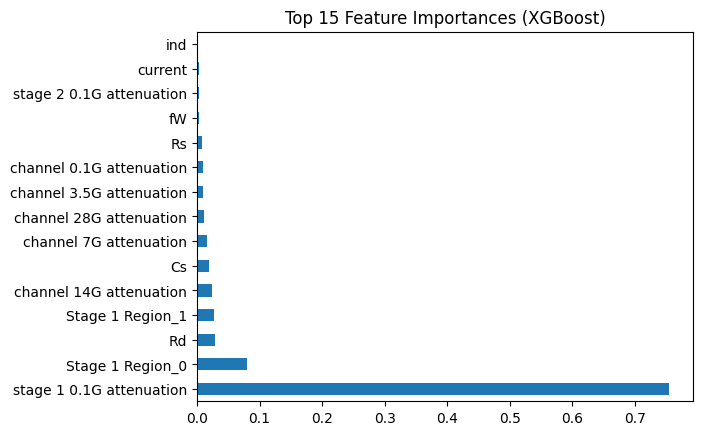

In [60]:
# Create a plot
feat_importances = pd.Series(feature_importances, index=feature_names)
feat_importances.nlargest(15).plot(kind="barh")
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()

In [61]:
xgb_results = evaluate_model(y_test, xgb_pred, "XGBoost")
all_results["XGBoost"] = xgb_results
print_results(xgb_results, "XGBoost")


XGBoost RESULTS

Overall Performance:
RMSE: 0.7099
MAE:  0.2698
R²:   0.5643

Per-Target Performance:
stage 1 3.5G attenuation:
  RMSE: 1.2002
  MAE:  0.7916
  R²:   0.9963
  MAPE: 70.84%
stage 2 3.5G attenuation:
  RMSE: 1.5404
  MAE:  1.0068
  R²:   0.9923
  MAPE: 21.67%
stage 1 7G attenuation:
  RMSE: 1.0579
  MAE:  0.7034
  R²:   0.9970
  MAPE: 4.21%
stage 2 7G attenuation:
  RMSE: 1.4801
  MAE:  0.9276
  R²:   0.9929
  MAPE: 17.70%
stage 1 14G attenuation:
  RMSE: 0.9291
  MAE:  0.6325
  R²:   0.9975
  MAPE: 2.68%
stage 2 14G attenuation:
  RMSE: 1.3335
  MAE:  0.8638
  R²:   0.9945
  MAPE: 9.38%
stage 1 28G attenuation:
  RMSE: 0.8505
  MAE:  0.5679
  R²:   0.9978
  MAPE: 1.88%
stage 2 28G attenuation:
  RMSE: 1.2623
  MAE:  0.8094
  R²:   0.9957
  MAPE: 4.04%
eye_maxHeight Vout_1 7G:
  RMSE: 0.0344
  MAE:  0.0251
  R²:   0.9586
  MAPE: 13.79%
eye_maxWidth Vout_1 7G:
  RMSE: 0.0000
  MAE:  0.0000
  R²:   -0.0002
  MAPE: 11.30%
eye_maxHeight Vout_2 7G:
  RMSE: 0.0482
  MAE:  0.02

In [62]:
print(f"\nBest XGBoost Parameters: {xgb_grid.best_params_}")
print(f"Best XGBoost CV Score: {-xgb_grid.best_score_:.4f}")


Best XGBoost Parameters: {'estimator__subsample': 0.8, 'estimator__reg_lambda': 1.3, 'estimator__reg_alpha': 0.01, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 5, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.1, 'estimator__gamma': 0.2, 'estimator__colsample_bytree': 0.9}
Best XGBoost CV Score: 0.6231


Best XGBoost Parameters: {'estimator__subsample': 0.8, 'estimator__reg_lambda': 1.5, 'estimator__reg_alpha': 0.1, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 5, 'estimator__max_depth': 7, 'estimator__learning_rate': 0.1, 'estimator__gamma': 0.1, 'estimator__colsample_bytree': 0.9}
Best XGBoost CV Score: 0.5959

### LightGBM


In [63]:
lgb_model = MultiOutputRegressor(
    LGBMRegressor(objective="regression", random_state=42, n_jobs=-1)
)

In [ ]:
# LightGBM hyperparameter grid
# lgb_param_grid = {
#     "estimator__n_estimators": [100, 300],
#     "estimator__learning_rate": [0.01, 0.1, 0.2],
#     "estimator__max_depth": [3, 5, 7],
#     "estimator__min_child_samples": [10, 20, 30],
#     "estimator__min_child_weight": [1, 3, 5],
#     "estimator__subsample": [0.8, 0.9, 1.0],
#     "estimator__colsample_bytree": [0.8, 0.9, 1.0],
#     "estimator__reg_alpha": [0, 0.01, 0.1],
#     "estimator__reg_lambda": [0, 0.01, 0.1],
# }

lgb_param_grid = {
    "estimator__subsample": [1.0],
    "estimator__reg_lambda": [0.01],
    "estimator__reg_alpha": [0.01],
    "estimator__n_estimators": [300],
    "estimator__min_child_weight": [1],
    "estimator__min_child_samples": [20],
    "estimator__max_depth": [7],
    "estimator__learning_rate": [0.2],
    "estimator__colsample_bytree": [1.0],
}

# {
#     "estimator__subsample": 1.0,
#     "estimator__reg_lambda": 0.01,
#     "estimator__reg_alpha": 0.01,
#     "estimator__n_estimators": 300,
#     "estimator__min_child_weight": 1,
#     "estimator__min_child_samples": 20,
#     "estimator__max_depth": 7,
#     "estimator__learning_rate": 0.2,
#     "estimator__colsample_bytree": 1.0,
# }

In [65]:
# lgb_grid = GridSearchCV(
#     estimator=lgb_model,
#     param_grid=lgb_param_grid,
#     cv=2,
#     scoring="neg_mean_squared_error",
#     verbose=1,
#     n_jobs=-1,
# )

In [66]:
lgb_grid = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=lgb_param_grid,
    n_iter=10,
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=1,
)

In [67]:
lgb_grid.fit(X_train_df, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2199
[LightGBM] [Info] Number of data points in the train set: 5600, number of used features: 15
[LightGBM] [Info] Start training from score -25.776614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

RandomizedSearchCV(cv=5,
                   estimator=MultiOutputRegressor(estimator=LGBMRegressor(n_jobs=-1,
                                                                          objective='regression',
                                                                          random_state=42)),
                   n_jobs=1,
                   param_distributions={'estimator__colsample_bytree': [1.0],
                                        'estimator__learning_rate': [0.2],
                                        'estimator__max_depth': [5],
                                        'estimator__min_child_samples': [10],
                                        'estimator__min_child_weight': [3],
                                        'estimator__n_estimators': [300],
                                        'estimator__reg_alpha': [0.1],
                                        'estimator__reg_lambda': [0.01],
                                        'estimator__subsample': [1.0]},
                   scoring='neg_mean_squared_error', verbose=1)

In [68]:
# Best LightGBM model
best_lgb = lgb_grid.best_estimator_
lgb_pred = best_lgb.predict(X_test_df)

In [69]:
lgb_results = evaluate_model(y_test, lgb_pred, "LightGBM")
print(lgb_results)

all_results["LightGBM"] = lgb_results

print_results(lgb_results, "LightGBM")

{'overall': {'RMSE': np.float64(0.7282947607803629), 'MAE': 0.27226100860737584, 'R²': 0.6371839619700203}, 'per_target': {'stage 1 3.5G attenuation': {'RMSE': np.float64(1.1939205125297578), 'MAE': 0.7842220411962947, 'R²': 0.9963171322496521, 'MAPE': np.float64(26.103174301134224)}, 'stage 2 3.5G attenuation': {'RMSE': np.float64(1.6413428819173148), 'MAE': 1.054511343081741, 'R²': 0.9912586617559628, 'MAPE': np.float64(21.461484487254083)}, 'stage 1 7G attenuation': {'RMSE': np.float64(1.0782597748169158), 'MAE': 0.713168756988506, 'R²': 0.996891820537811, 'MAPE': np.float64(4.2418121432876)}, 'stage 2 7G attenuation': {'RMSE': np.float64(1.494249448943089), 'MAE': 0.9558731729091514, 'R²': 0.992761068885902, 'MAPE': np.float64(20.001177454421683)}, 'stage 1 14G attenuation': {'RMSE': np.float64(0.9580228443152563), 'MAE': 0.639466655221355, 'R²': 0.9973899355637971, 'MAPE': np.float64(2.719009312518155)}, 'stage 2 14G attenuation': {'RMSE': np.float64(1.3512557559162766), 'MAE': 0.

In [70]:
print(f"\nBest LightGBM Parameters: {lgb_grid.best_params_}")
print(f"Best LightGBM CV Score: {-lgb_grid.best_score_:.4f}")


Best LightGBM Parameters: {'estimator__subsample': 1.0, 'estimator__reg_lambda': 0.01, 'estimator__reg_alpha': 0.1, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 3, 'estimator__min_child_samples': 10, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.2, 'estimator__colsample_bytree': 1.0}
Best LightGBM CV Score: 0.6667


Best LightGBM Parameters: {'estimator__subsample': 1.0, 'estimator__reg_lambda': 0.01, 'estimator__reg_alpha': 0.01, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 1, 'estimator__min_child_samples': 20, 'estimator__max_depth': 7, 'estimator__learning_rate': 0.2, 'estimator__colsample_bytree': 1.0}
Best LightGBM CV Score: 0.6574

### DNN


In [71]:
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

In [72]:
# Create MLP model
mlp_model = MultiOutputRegressor(
    MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        activation="relu",
        solver="adam",
        alpha=0.001,
        learning_rate_init=0.001,
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        random_state=42,
    )
)

In [ ]:
# Hyperparameter grid
# mlp_param_grid = {
#     "estimator__hidden_layer_sizes": [
#         (128, 64, 32),  # Deep narrow
#         (256, 128, 64),  # Deeper & wider
#         (512, 256),  # Two wide layers
#         (256, 128),  # Shallower
#         (128, 128, 128),  # Uniform depth
#         (64, 64),  # Smaller net
#         (256, 256, 256),  # Deep & consistent
#     ],
#     "estimator__alpha": [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.0],
#     "estimator__learning_rate_init": [1e-4, 1e-3, 1e-2, 0.01, 0.05],
#     "estimator__activation": ["identity", "logistic", "tanh", "relu"],
#     "estimator__solver": ["lbfgs", "adam", "sgd"],
#     "estimator__batch_size": [16, 32, 64, 128],
#     "estimator__max_iter": [200, 300, 500, 1000],
#     "estimator__learning_rate": ["constant", "invscaling", "adaptive"],
#     "estimator__momentum": [0.8, 0.9, 0.95, 0.99],
# }

mlp_param_grid = {
    "estimator__hidden_layer_sizes": [
        (128, 64, 32),  # Best
    ],
    "estimator__alpha": [0.1],
    "estimator__learning_rate_init": [0.01],
    "estimator__activation": [
        "tanh",
    ],
    "estimator__solver": [
        "lbfgs",
    ],
    "estimator__batch_size": [
        32,
    ],
    # "estimator__max_iter": [
    #     200,  # Default
    #     500,  # More iterations
    #     1000,  # Many iterations
    # ],
    "estimator__learning_rate": [
        "constant",  # Fixed learning rate
    ],
    # "estimator__momentum": [
    #     0.9,  # Default
    #     0.95,  # Higher momentum
    #     0.99,  # Very high momentum
    # ],
}

# {
#     "estimator__activation": "tanh",
#     "estimator__alpha": 0.1,
#     "estimator__batch_size": 32,
#     "estimator__hidden_layer_sizes": (128, 64, 32),
#     "estimator__learning_rate": "constant",
#     "estimator__learning_rate_init": 0.01,
#     "estimator__solver": "lbfgs",
# }

In [74]:
# Grid search
mlp_grid = GridSearchCV(
    estimator=mlp_model,
    param_grid=mlp_param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=1,
)

In [75]:
# Fit model
mlp_grid.fit(X_train_df, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=MultiOutputRegressor(estimator=MLPRegressor(alpha=0.001,
                                                                   early_stopping=True,
                                                                   hidden_layer_sizes=(128,
                                                                                       64,
                                                                                       32),
                                                                   max_iter=500,
                                                                   n_iter_no_change=20,
                                                                   random_state=42)),
             n_jobs=1,
             param_grid={'estimator__activation': ['tanh'],
                         'estimator__alpha': [0.1],
                         'estimator__batch_size': [32],
                         'estimator__hidden_layer_sizes': [(128, 64, 32)],
                         'estimator__learning_rate': ['constant'],
                         'estimator__learning_rate_init': [0.01],
                         'estimator__solver': ['lbfgs']},
             scoring='neg_mean_squared_error', verbose=1)

In [76]:
# Get best model and predictions
best_dnn = mlp_grid.best_estimator_  # Keep variable name for consistency
dnn_pred = best_dnn.predict(X_test_df)

In [77]:
# Evaluate
dnn_results = evaluate_model(y_test, dnn_pred, "MLP Neural Network")
print(dnn_results)

{'overall': {'RMSE': np.float64(0.4243691498835942), 'MAE': 0.11991377048063755, 'R²': -1.0298309266979112e+18}, 'per_target': {'stage 1 3.5G attenuation': {'RMSE': np.float64(0.6975357666010853), 'MAE': 0.31121067414552006, 'R²': 0.9987429045375706, 'MAPE': np.float64(77.9649333932612)}, 'stage 2 3.5G attenuation': {'RMSE': np.float64(0.8730376946778362), 'MAE': 0.3666403059361141, 'R²': 0.9975268794614472, 'MAPE': np.float64(7.273013419179812)}, 'stage 1 7G attenuation': {'RMSE': np.float64(0.5561934926866259), 'MAE': 0.2917641499070911, 'R²': 0.9991729893818917, 'MAPE': np.float64(1.9180154966720753)}, 'stage 2 7G attenuation': {'RMSE': np.float64(0.8232221413709644), 'MAE': 0.34476918226163933, 'R²': 0.9978028367792084, 'MAPE': np.float64(7.302119598192122)}, 'stage 1 14G attenuation': {'RMSE': np.float64(0.5479461038537584), 'MAE': 0.2863192065053047, 'R²': 0.9991461625773025, 'MAPE': np.float64(1.2432634914923986)}, 'stage 2 14G attenuation': {'RMSE': np.float64(0.869229439026223

In [78]:
all_results["MLP"] = dnn_results
print_results(dnn_results, "MLP Neural Network")


MLP Neural Network RESULTS

Overall Performance:
RMSE: 0.4244
MAE:  0.1199
R²:   -1029830926697911168.0000

Per-Target Performance:
stage 1 3.5G attenuation:
  RMSE: 0.6975
  MAE:  0.3112
  R²:   0.9987
  MAPE: 77.96%
stage 2 3.5G attenuation:
  RMSE: 0.8730
  MAE:  0.3666
  R²:   0.9975
  MAPE: 7.27%
stage 1 7G attenuation:
  RMSE: 0.5562
  MAE:  0.2918
  R²:   0.9992
  MAPE: 1.92%
stage 2 7G attenuation:
  RMSE: 0.8232
  MAE:  0.3448
  R²:   0.9978
  MAPE: 7.30%
stage 1 14G attenuation:
  RMSE: 0.5479
  MAE:  0.2863
  R²:   0.9991
  MAPE: 1.24%
stage 2 14G attenuation:
  RMSE: 0.8692
  MAE:  0.4038
  R²:   0.9977
  MAPE: 8.06%
stage 1 28G attenuation:
  RMSE: 0.5639
  MAE:  0.2935
  R²:   0.9990
  MAPE: 1.03%
stage 2 28G attenuation:
  RMSE: 0.8415
  MAE:  0.4278
  R²:   0.9981
  MAPE: 2.21%
eye_maxHeight Vout_1 7G:
  RMSE: 0.0184
  MAE:  0.0133
  R²:   0.9882
  MAPE: 7.43%
eye_maxWidth Vout_1 7G:
  RMSE: 0.0061
  MAE:  0.0044
  R²:   -158194090926127680.0000
  MAPE: 3777329092.66%


In [79]:
print(f"\nBest MLP Parameters: {mlp_grid.best_params_}")
print(f"Best MLP CV Score: {-mlp_grid.best_score_:.4f}")


Best MLP Parameters: {'estimator__activation': 'tanh', 'estimator__alpha': 0.1, 'estimator__batch_size': 32, 'estimator__hidden_layer_sizes': (128, 64, 32), 'estimator__learning_rate': 'constant', 'estimator__learning_rate_init': 0.01, 'estimator__solver': 'lbfgs'}
Best MLP CV Score: 0.1986


Best MLP Parameters: {'estimator__activation': 'tanh', 'estimator__alpha': 0.1, 'estimator__hidden_layer_sizes': (128, 64, 32), 'estimator__learning_rate_init': 0.01, 'estimator__solver': 'lbfgs'}
Best MLP CV Score: 0.8181

Best MLP Parameters: {'estimator__activation': 'tanh', 'estimator__alpha': 0.1, 'estimator__batch_size': 32, 'estimator__hidden_layer_sizes': (128, 64, 32), 'estimator__learning_rate': 'constant', 'estimator__learning_rate_init': 0.01, 'estimator__solver': 'lbfgs'}
Best MLP CV Score: 0.8181

## Comparison Summary


In [80]:
comparison_data = []

In [81]:
for model_name, results in all_results.items():
    comparison_data.append(
        {
            "Model": model_name,
            "Overall_RMSE": results["overall"]["RMSE"],
            "Overall_MAE": results["overall"]["MAE"],
            "Overall_R²": results["overall"]["R²"],
        }
    )

In [82]:
comparison_df = pd.DataFrame(comparison_data)

In [83]:
# Sort by R² (descending)
comparison_df = comparison_df.sort_values("Overall_R²", ascending=False)

In [84]:
print("\nOverall Performance Ranking:")
print(comparison_df.to_string(index=False, float_format="%.4f"))


Overall Performance Ranking:
   Model  Overall_RMSE  Overall_MAE                Overall_R²
LightGBM        0.7283       0.2723                    0.6372
 XGBoost        0.7099       0.2698                    0.5643
     MLP        0.4244       0.1199 -1029830926697911168.0000


In [85]:
best_model_name = comparison_df.iloc[0]["Model"]
print(f"\nBest performing model: {best_model_name}")
print(f"Best R² score: {comparison_df.iloc[0]['Overall_R²']:.4f}")


Best performing model: LightGBM
Best R² score: 0.6372


In [86]:
# Create visualization
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

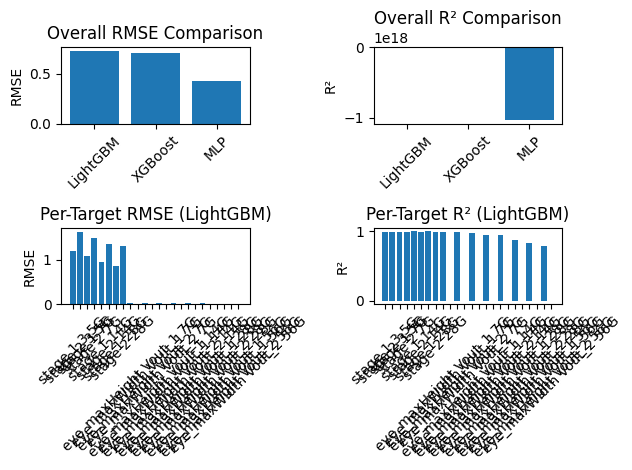

In [87]:
# Plot 1: Overall RMSE comparison
plt.subplot(2, 2, 1)
plt.bar(comparison_df["Model"], comparison_df["Overall_RMSE"])
plt.title("Overall RMSE Comparison")
plt.xticks(rotation=45)
plt.ylabel("RMSE")

# Plot 2: Overall R² comparison
plt.subplot(2, 2, 2)
plt.bar(comparison_df["Model"], comparison_df["Overall_R²"])
plt.title("Overall R² Comparison")
plt.xticks(rotation=45)
plt.ylabel("R²")

# Plot 3: Per-target RMSE for best model
plt.subplot(2, 2, 3)
best_results = all_results[best_model_name]
targets = list(best_results["per_target"].keys())
rmse_values = [best_results["per_target"][t]["RMSE"] for t in targets]
plt.bar(range(len(targets)), rmse_values)
plt.title(f"Per-Target RMSE ({best_model_name})")
plt.xticks(
    range(len(targets)), [t.replace(" attenuation", "") for t in targets], rotation=45
)
plt.ylabel("RMSE")

# Plot 4: Per-target R² for best model
plt.subplot(2, 2, 4)
r2_values = [best_results["per_target"][t]["R²"] for t in targets]
plt.bar(range(len(targets)), r2_values)
plt.title(f"Per-Target R² ({best_model_name})")
plt.xticks(
    range(len(targets)), [t.replace(" attenuation", "") for t in targets], rotation=45
)
plt.ylabel("R²")

plt.tight_layout()
plt.show()

In [88]:
print("\nDetailed Performance Comparison:")
print("=" * 80)
for model_name in comparison_df["Model"]:
    results = all_results[model_name]
    print(f"\n{model_name}:")
    print(f"  Overall RMSE: {results['overall']['RMSE']:.4f}")
    print(f"  Overall MAE:  {results['overall']['MAE']:.4f}")
    print(f"  Overall R²:   {results['overall']['R²']:.4f}")


Detailed Performance Comparison:

LightGBM:
  Overall RMSE: 0.7283
  Overall MAE:  0.2723
  Overall R²:   0.6372

XGBoost:
  Overall RMSE: 0.7099
  Overall MAE:  0.2698
  Overall R²:   0.5643

MLP:
  Overall RMSE: 0.4244
  Overall MAE:  0.1199
  Overall R²:   -1029830926697911168.0000


## Improvements

In [89]:
import shap

# Use the KernelExplainer for your MLP, as it's model-agnostic
# For tree models like XGBoost, use shap.TreeExplainer for much faster performance
explainer = shap.KernelExplainer(
    best_dnn.predict, shap.sample(X_train_df, 50)
)  # Summarize training data
shap_values = explainer.shap_values(X_test_df)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [90]:
# Add this code to your notebook to debug
print(f"Type of shap_values: {type(shap_values)}")

# If it's a list, check the shape of its elements
if isinstance(shap_values, list):
    print(f"Length of shap_values list: {len(shap_values)}")
    print(f"Shape of the first element: {shap_values[0].shape}")
# If it's a numpy array, just check its shape
else:
    print(f"Shape of shap_values array: {shap_values.shape}")

print(f"Shape of X_test_df: {X_test_df.shape}")

Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values array: (3000, 15, 24)
Shape of X_test_df: (3000, 15)


SHAP Summary Plot for Class 0


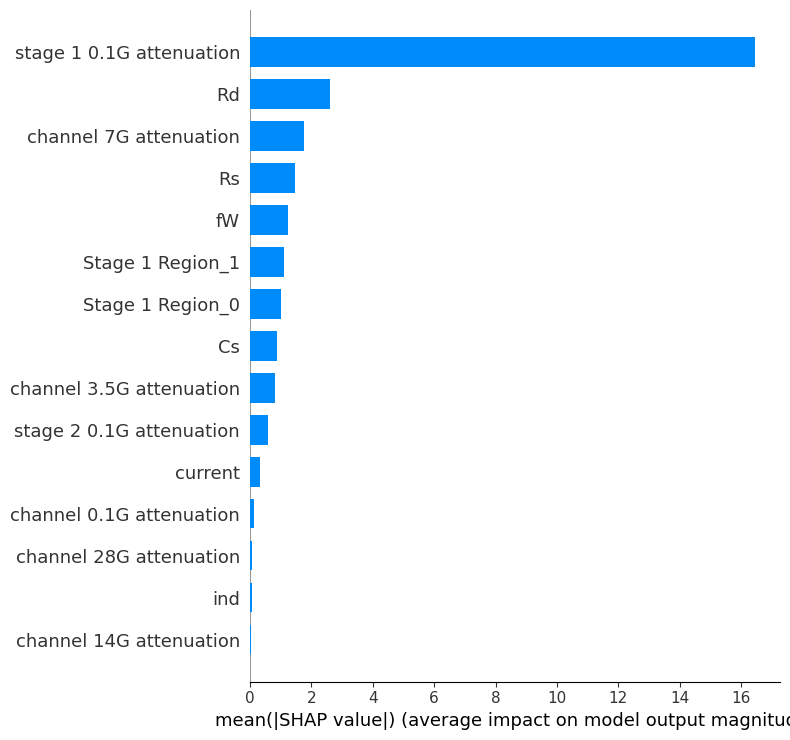

SHAP Summary Plot for Class 1


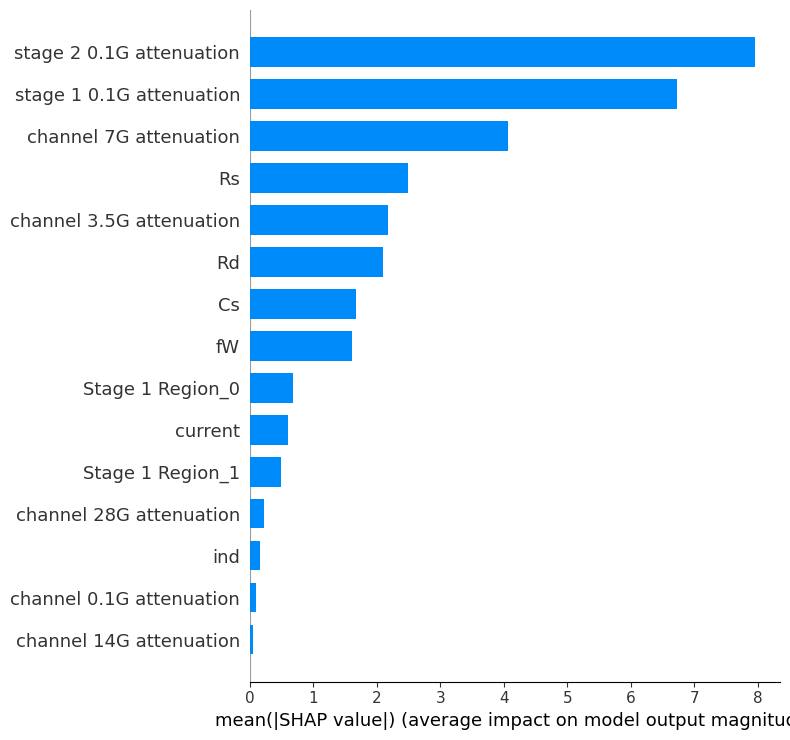

SHAP Summary Plot for Class 2


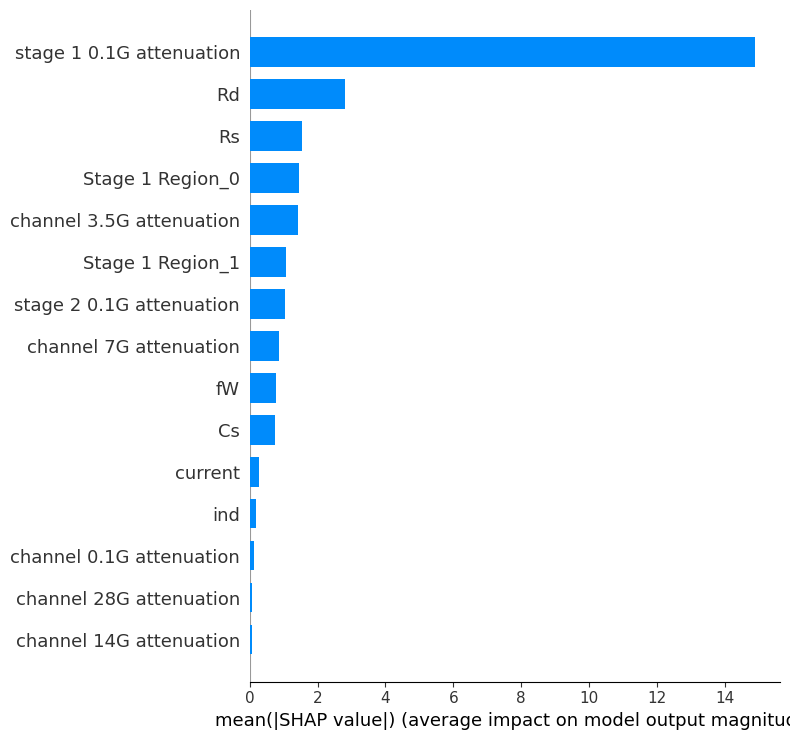

SHAP Summary Plot for Class 3


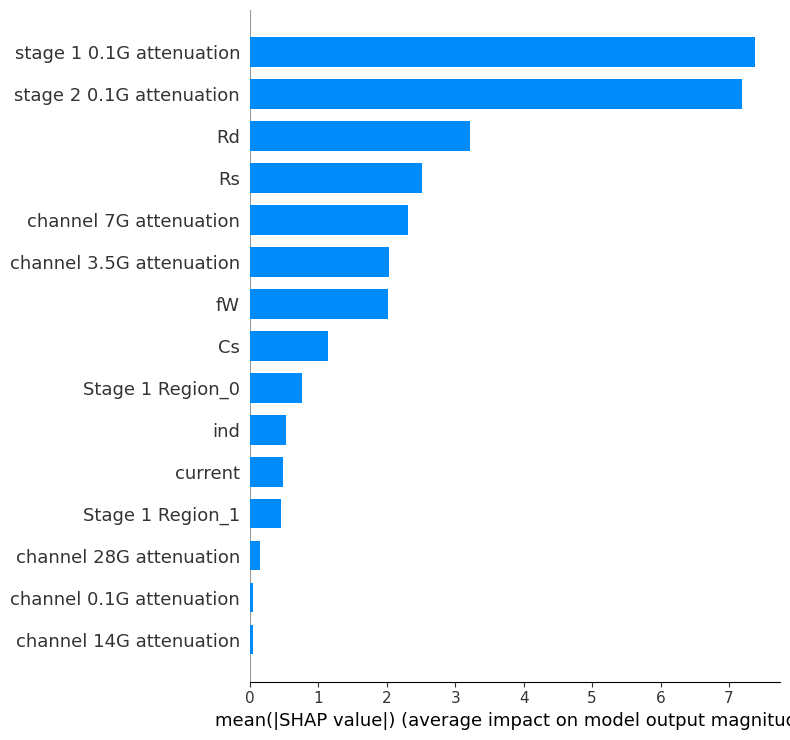

SHAP Summary Plot for Class 4


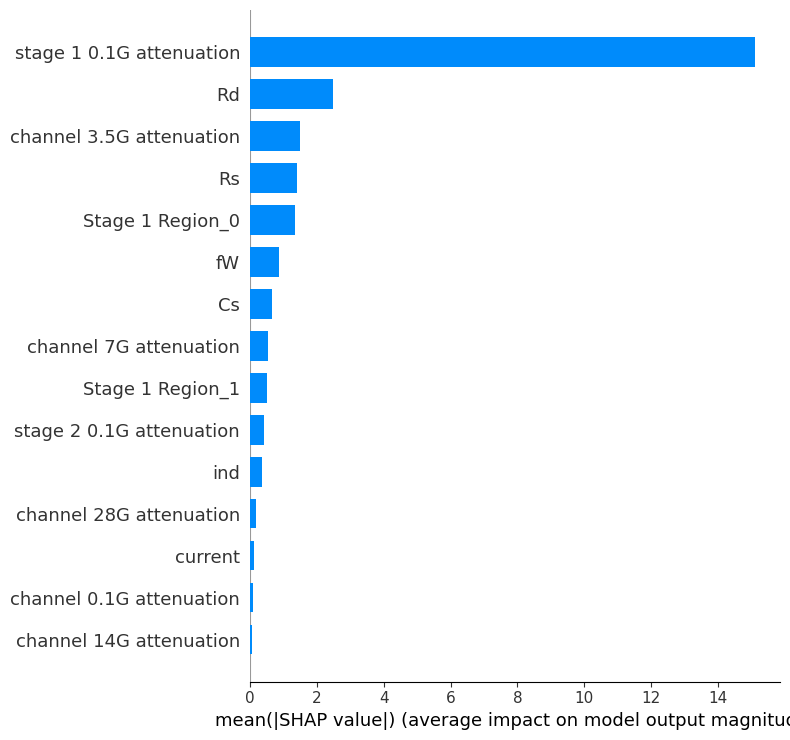

SHAP Summary Plot for Class 5


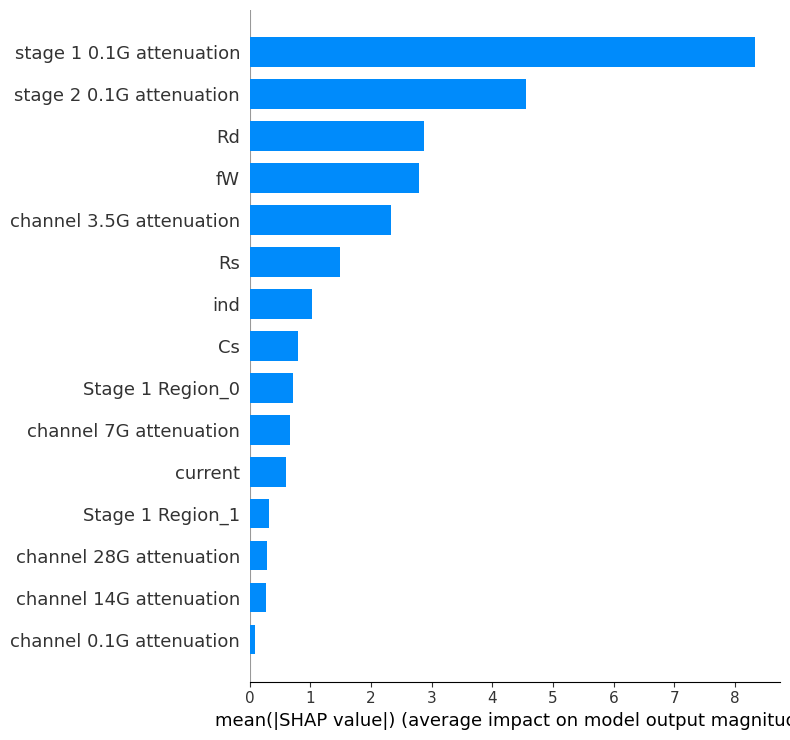

SHAP Summary Plot for Class 6


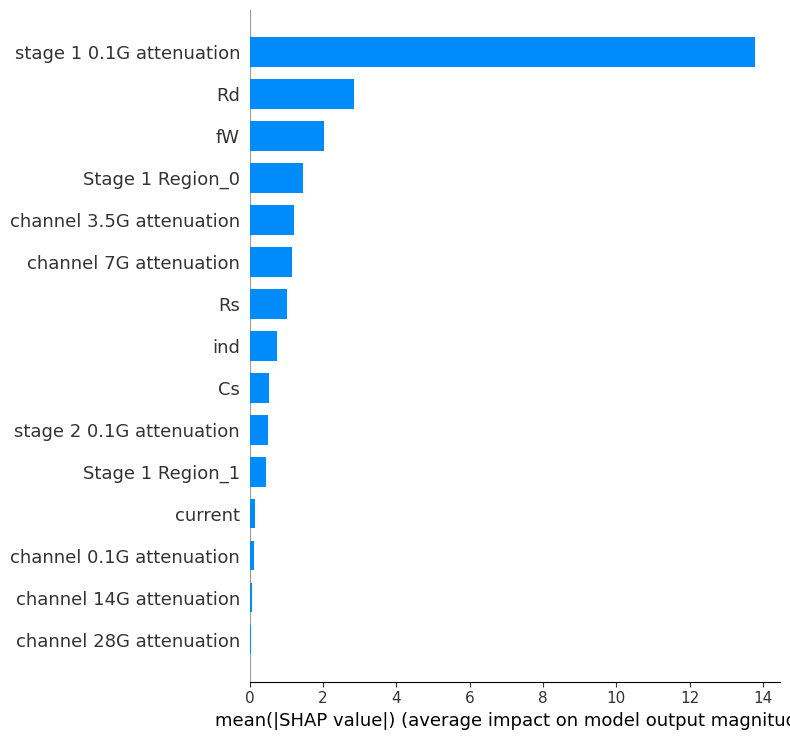

SHAP Summary Plot for Class 7


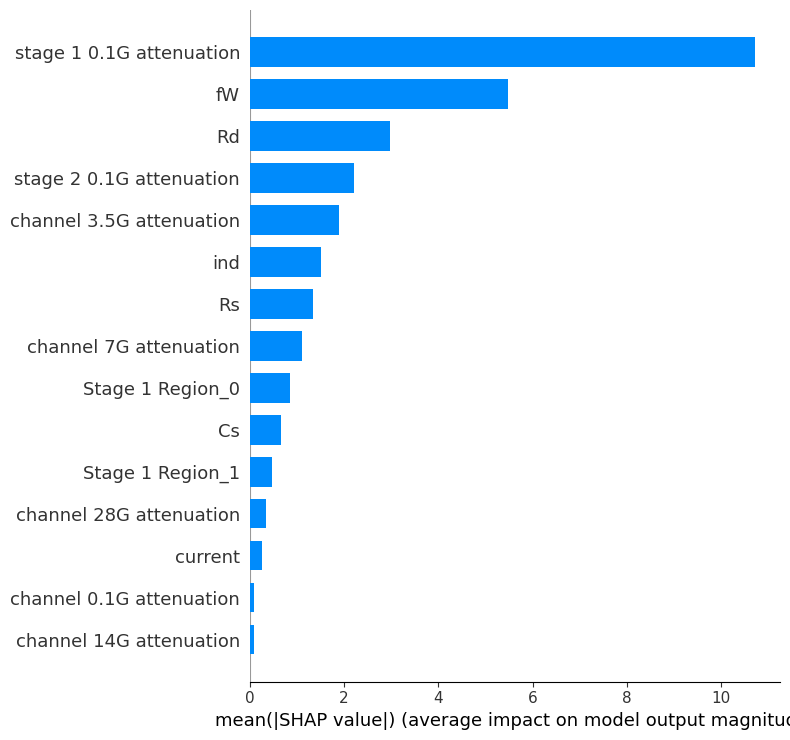

In [91]:
# Loop through all 8 classes and create a summary plot for each
for i in range(8):
    print(f"SHAP Summary Plot for Class {i}")
    shap.summary_plot(shap_values[:, :, i], X_test_df, plot_type="bar", show=True)

## Bayesian Search

In [92]:
# pip install scikit-optimize

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

mlp_search_space = {
    # Let the optimizer choose the number of neurons in each layer
    "estimator__hidden_layer_sizes": Integer(32, 128),
    "estimator__alpha": Real(1e-4, 1e-1, prior="log-uniform"),
    "estimator__learning_rate_init": Real(1e-4, 1e-2, prior="log-uniform"),
}

# Setup the Bayesian Search (rest of the code is the same)
bayes_search = BayesSearchCV(
    estimator=mlp_model,
    search_spaces=mlp_search_space,
    n_iter=32,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

bayes_search.fit(X_train_df, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3,
              estimator=MultiOutputRegressor(estimator=MLPRegressor(alpha=0.001,
                                                                    early_stopping=True,
                                                                    hidden_layer_sizes=(128,
                                                                                        64,
                                                                                        32),
                                                                    max_iter=500,
                                                                    n_iter_no_change=20,
                                                                    random_state=42)),
              n_iter=32, n_jobs=-1, scoring='neg_mean_squared_error',
              search_spaces={'estimator__alpha': Real(low=0.0001, high=0.1, prior='log-uniform', transform='normalize'),
                             'estimator__hidden_layer_sizes': Integer(low=32, high=128, prior='uniform', transform='normalize'),
                             'estimator__learning_rate_init': Real(low=0.0001, high=0.01, prior='log-uniform', transform='normalize')},
              verbose=1)

In [ ]:
# Retrieve the best model with the optimal hyperparameters
best_model = bayes_search.best_estimator_

# Use the best model to make predictions on the unseen test data
y_pred = best_model.predict(X_test)

# Calculate the performance metric (e.g., Mean Squared Error)
# Use the same metric family as your 'scoring' parameter for consistency
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Or Root Mean Squared Error for easier interpretation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Set MSE: {mse:.4f}")
print(f"Test Set RMSE: {rmse:.4f}")
print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set R²: {r2:.4f}")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Hard Constraint of neg2 on 0.1G Status
- Stage 1 Region
Feature names seen at fit time, yet now missing:
- Stage 1 Region_0
- Stage 1 Region_1


In [ ]:
results_df = pd.DataFrame(bayes_search.cv_results_)

# Sort by rank to see the best results at the top
results_df.sort_values(by="rank_test_score", inplace=True)

# Display the top 5 performing hyperparameter sets
print(
    results_df[
        [
            "rank_test_score",
            "mean_test_score",
            "param_estimator__hidden_layer_sizes",
            "param_estimator__alpha",
        ]
    ].head()
)

## Ensemble of DNNs


--- Starting Training for 8 Independent DNNs ---
Training model for: stage 1 3.5G attenuation...
Finished training for stage 1 3.5G attenuation. Final validation loss: 1.3459
Training model for: stage 2 3.5G attenuation...
Finished training for stage 2 3.5G attenuation. Final validation loss: 2.2957
Training model for: stage 1 7G attenuation...
Finished training for stage 1 7G attenuation. Final validation loss: 1.5219
Training model for: stage 2 7G attenuation...
Finished training for stage 2 7G attenuation. Final validation loss: 2.0617
Training model for: stage 1 14G attenuation...
Finished training for stage 1 14G attenuation. Final validation loss: 1.5641
Training model for: stage 2 14G attenuation...
Finished training for stage 2 14G attenuation. Final validation loss: 2.6889
Training model for: stage 1 28G attenuation...
Finished training for stage 1 28G attenuation. Final validation loss: 2.1502
Training model for: stage 2 28G attenuation...
Finished training for stage 2 28G a

IndexError: index 8 is out of bounds for axis 0 with size 8

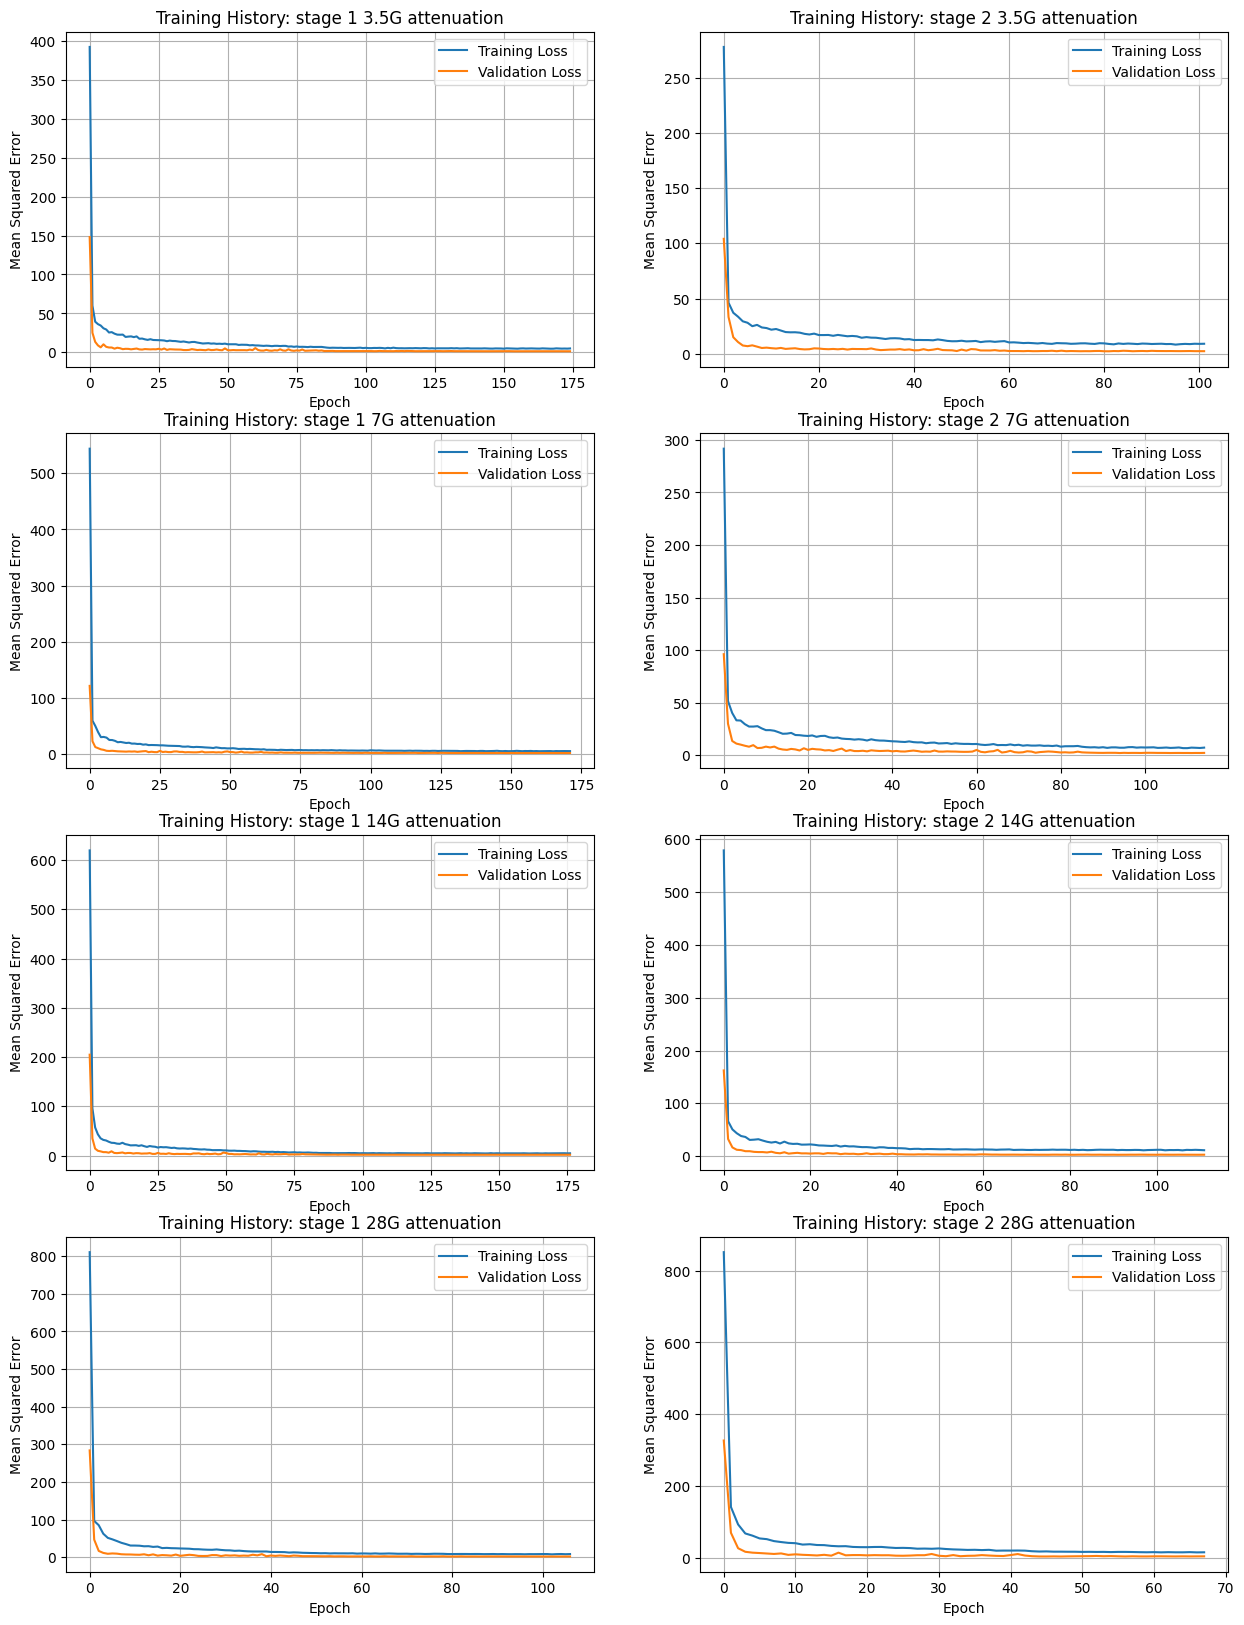

In [95]:
# --- DNN Model Definition ---
def create_dnn_model(input_dim):
    """Creates a compiled Keras Sequential model for single-target regression."""
    model = Sequential(
        [
            Dense(128, activation="relu", input_dim=input_dim),
            BatchNormalization(),
            Dropout(0.3),
            Dense(64, activation="relu"),
            BatchNormalization(),
            Dropout(0.3),
            Dense(32, activation="relu"),
            Dense(1),  # Single output neuron
        ]
    )

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    return model


# %%
# --- Training the Ensemble of DNNs ---
trained_models = {}
training_history = {}

# Callbacks for training
early_stopping = EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=10, min_lr=1e-6)

print("\n--- Starting Training for Independent DNNs ---")

for target in target_cols:
    print(f"Training model for: {target}...")

    # Select the single target column for this model
    y_train_target = y_train[target]

    # Create a new KerasRegressor instance for each target
    # This ensures each model is fresh
    input_dimension = X_train_df.shape[1]
    model_for_target = KerasRegressor(
        model=lambda: create_dnn_model(input_dimension),
        epochs=200,
        batch_size=32,
        verbose=0,  # Keep the output clean during the loop
        callbacks=[early_stopping, reduce_lr],
        validation_split=0.15,  # Use a portion of training data for validation
    )

    # Fit the model
    history = model_for_target.fit(X_train_df, y_train_target)

    # Store the trained model and its history
    trained_models[target] = model_for_target
    training_history[target] = history.history_

    print(
        f"Finished training for {target}. Final validation loss: {min(history.history_['val_loss']):.4f}"
    )

print("\n--- All models trained successfully! ---")

# %%
# --- Prediction and Evaluation ---


# Function to evaluate the final ensemble predictions
def evaluate_ensemble(y_true, y_pred_df, model_name="DNN Ensemble"):
    results = {}
    y_pred = y_pred_df.values  # Convert to numpy array for metrics

    # Overall metrics
    results["overall"] = {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred),
    }

    # Per-target metrics
    results["per_target"] = {}
    for i, col in enumerate(y_true.columns):
        results["per_target"][col] = {
            "RMSE": np.sqrt(mean_squared_error(y_true.iloc[:, i], y_pred[:, i])),
            "MAE": mean_absolute_error(y_true.iloc[:, i], y_pred[:, i]),
            "R²": r2_score(y_true.iloc[:, i], y_pred[:, i]),
        }

    # Print results
    print(f"\n{'='*60}\n{model_name} RESULTS\n{'='*60}")
    print(
        f"\nOverall Performance:\n"
        f"RMSE: {results['overall']['RMSE']:.4f}\n"
        f"MAE:  {results['overall']['MAE']:.4f}\n"
        f"R²:   {results['overall']['R²']:.4f}"
    )
    print("\nPer-Target Performance:")
    for target, metrics in results["per_target"].items():
        print(
            f"  {target}:\n"
            f"    RMSE: {metrics['RMSE']:.4f}, MAE: {metrics['MAE']:.4f}, R²: {metrics['R²']:.4f}"
        )

    return results


# Make predictions with each specialized model
predictions = {}
for target, model in trained_models.items():
    print(f"Predicting for: {target}...")
    predictions[target] = model.predict(X_test_df)

# Combine predictions into a single DataFrame
predictions_df = pd.DataFrame(predictions, index=X_test.index)

# Evaluate the final results
ensemble_results = evaluate_ensemble(y_test, predictions_df)

# %%
# --- Visualization ---
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

for i, (target, history) in enumerate(training_history.items()):
    ax = axes[i]
    ax.plot(history["loss"], label="Training Loss")
    ax.plot(history["val_loss"], label="Validation Loss")
    ax.set_title(f"Training History: {target}", fontsize=12)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Mean Squared Error")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# Visualize overall performance
overall_metrics = pd.DataFrame(ensemble_results["overall"], index=[0])
per_target_r2 = {k: v["R²"] for k, v in ensemble_results["per_target"].items()}

plt.figure(figsize=(12, 5))
plt.bar(per_target_r2.keys(), per_target_r2.values())
plt.axhline(
    y=ensemble_results["overall"]["R²"],
    color="r",
    linestyle="--",
    label=f"Overall R²: {ensemble_results['overall']['R²']:.4f}",
)
plt.title("Per-Target R² Score for DNN Ensemble")
plt.xlabel("Target Attenuation")
plt.ylabel("R² Score")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()